## 1. The Example Data-Generating Process

Logistic map with a binary generating partition

The logistic map is
$$x_{i+1} = r x_i (1 - x_i)$$

And we will report 0 or 1 from the map, according to
$$d_i = \begin{cases} 0 & \text{if $x_i < .5$} \\ 1 & \text{else} \end{cases}$$

In [ ]:
binlogmap = function(rr, NN=1000, init=pi / 4) {
    xx = init
    dd = rep(0, NN)
    for (ii in 1:NN) {
        xx = rr * xx * (1 - xx)
        dd[ii] = xx >= .5
    }
    dd
}

In [ ]:
xx = binlogmap(3.5)

In [ ]:
plot(xx, type='l', xlim=c(1, 100))

## 2. Approach 1: Distributed lags model or VAR

$$x_i = \alpha + \sum_{l=1}^k \beta_l x_{i-l} + \epsilon_i$$

In [ ]:
df = data.frame(xx=binlogmap(3.5))

In [ ]:
library(dplyr)

In [ ]:
mod0 = lm(xx ~ 1, data=df)

In [ ]:
summary(mod0)

In [ ]:
mod1 = lm(xx ~ lag(xx), data=df)

In [ ]:
summary(mod1)

In [ ]:
mod2 = lm(xx ~ lag(xx) + lag(xx, 2), data=df)

In [ ]:
summary(mod2)

In [ ]:
mod3 = lm(xx ~ lag(xx) + lag(xx, 2) + lag(xx, 3), data=df)

In [ ]:
summary(mod3)

In [ ]:
rmse0 = sqrt(mean(mod0$resid^2))
rmse1 = sqrt(mean(mod1$resid^2))
rmse2 = sqrt(mean(mod2$resid^2))
rmse3 = sqrt(mean(mod3$resid^2))

In [ ]:
plot(c(rmse0, rmse1, rmse2, rmse3))

In [ ]:
allrmse = c()
for (kk in 0:30) {
    if (kk == 0) {
        text = "xx ~ 1"
    } else {
        text = paste("xx ~ 1 + ", paste(paste0("lag(xx, ", 1:kk, ")"), collapse=" + "))
    }
    
    mod = lm(as.formula(text), data=df)
    rmse = sqrt(mean(mod$resid^2))
    allrmse = c(allrmse, rmse)
}

In [ ]:
plot(allrmse)

## 3. Cross-validation for model selection

Calibrate the model to one set of data, then evaluate its performance on another set.

This addresses over-fitting.

In [ ]:
df.test = data.frame(xx=binlogmap(3.5, init=exp(1) / 3))

In [ ]:
xxpred = predict(mod, df.test)

In [ ]:
xxpred

In [ ]:
allrmse.test = c()
for (kk in 0:30) {
    if (kk == 0) {
        text = "xx ~ 1"
    } else {
        text = paste("xx ~ 1 + ", paste(paste0("lag(xx, ", 1:kk, ")"), collapse=" + "))
    }
    
    mod = lm(as.formula(text), data=df)
    xxpred = predict(mod, df.test)
    resids = xxpred - df.test$xx
    rmse = sqrt(mean(resids^2, na.rm=T))
    allrmse.test = c(allrmse.test, rmse)
}

In [ ]:
plot(allrmse, col=1)
points(allrmse.test, col=2)

In [ ]:
which.min(allrmse.test)

## 4. Let's see how this comparison evolves over values of $r$

In [ ]:
find.best.kk <- function(fit.predict) {
    allrmse.test = c()
    for (kk in 0:30) {
        xxpred = fit.predict(kk)
        resids = xxpred - df.test$xx
        rmse = sqrt(mean(resids^2, na.rm=T))
        allrmse.test = c(allrmse.test, rmse)
    }
    
    which.min(allrmse.test)
}

In [ ]:
lm.fp = function(kk) {
    if (kk == 0) {
        text = "xx ~ 1"
    } else {
        text = paste("xx ~ 1 + ", paste(paste0("lag(xx, ", 1:kk, ")"), collapse=" + "))
    }
    
    mod = lm(as.formula(text), data=df)
    suppressWarnings(predict(mod, df.test))
}

In [ ]:
find.best.kk(lm.fp)

In [ ]:
results = data.frame()
for (rr in seq(2, 4, length.out=100)) {
    print(rr)
    df = data.frame(xx=binlogmap(rr))
    df.test = data.frame(xx=binlogmap(rr, init=exp(1) / 3))
    opt.kk = find.best.kk(lm.fp)
    results = rbind(results, data.frame(rr, final.xx=df$xx[nrow(df)], opt.kk))
}

In [ ]:
plot(results$rr, results$opt.kk)

Compare this to the bifurcation diagram:
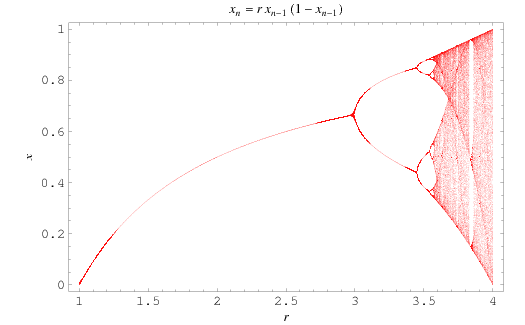

## 4. Optimal HMMs state choice

In [ ]:
library(depmixS4)

In [ ]:
mod <- depmix(response=xx ~ 1, data=df, nstates=1)

In [ ]:
hmm <- fit(mod)

In [ ]:
summary(hmm)

In [ ]:
mod <- depmix(response=xx ~ 1, data=df, nstates=2)

In [ ]:
hmm <- fit(mod)